## Zadanie 1
Napisz implementacje funkcji loss bazującej na notebooku NeRF, a następnie porównaj loss dla zdjęcia org z zdjęciami b1 ... b5.
Zrób wykresy ilustrujące loss względem każdego z zdjęć

In [30]:
import torch
import matplotlib.pyplot as pyplot
from PIL import Image
from torchvision import transforms


def load_image(path):
    image = Image.open(path)
    transform = transforms.PILToTensor()
    return transform(image)


def image_loss(input, target):
     # początek kodu niewidocznego dla studentów
    return (input.float()-target.float()).pow(2).mean()
     # koniec kodu niewidocznego dla studentów


def calculate_losses(org_tensor, tensors):
     # początek kodu niewidocznego dla studentów
    losses = []
    for tensor in tensors:
        mse_loss = image_loss(org_tensor, tensor)
        losses.append(mse_loss)
    return losses
     # koniec kodu niewidocznego dla studentów


Text(0, 0.5, 'Losses')

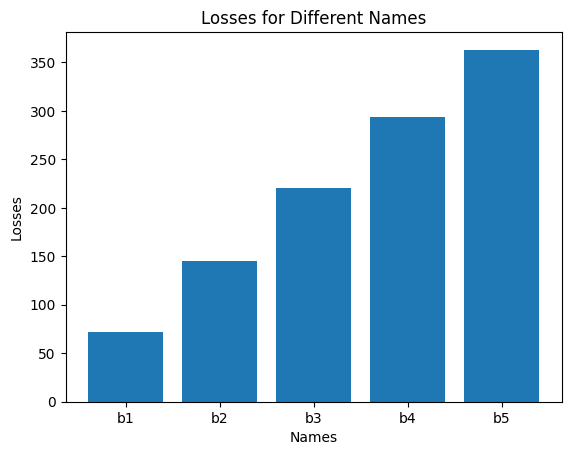

In [31]:
org_tensor = load_image('elza/org.jpg')
names = ['b' + str(i) for i in range(1, 6)]
tensors = [load_image('elza/' + name + '.jpg') for name in names]
losses = calculate_losses(org_tensor, tensors)

fig, ax = pyplot.subplots()
ax.bar(names, losses)
ax.set_title('Losses for Different Names')
ax.set_xlabel('Names')
ax.set_ylabel('Losses')

## Zadanie 2
Napisz i wytrenuj prosty model którego zadaniem bedzie klasyfikacja czy punkt znajduje sie wewnątrz koła jednostkowego czy może poza nim.
Następnie spróbuj użyć Fourier Feature do zmapowania wejścia. 
Poeksperymentuj z różnymi rodzajami transformacji ( parametr L oraz mnożenie przez macierz B).
Co się stanie gdy parametr L będzie mały?
Co się stanie gdy parametr L będzie duży?
Co się stanie jeżeli nie bedziemy mnożyć przez B?
Czy skalowanie macierzy B może poprawić wyniki sieci?

Wyciągnij wnioski i odpowiedz na powyższe pytania.
Odpowiedzi uzasadnij odpowiednimy wykresami.


<---- Miejsce na odpowiedź ---->

In [32]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import optim

L = 10  
N = 1000 
E = 500

def generate_data(size):
    data = np.random.uniform(-2., 2., (size, 2))
    labels = np.zeros(size)
    for i in range(size):
        if np.linalg.norm(data[i]) < 1.0:
            labels[i] = 1
    return torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

data_train, data_label_train = generate_data(N)
data_test, data_label_test = generate_data(N // 6)

criterion = torch.nn.BCELoss()

In [33]:
class RegularNet(nn.Module):
    def __init__(self):
        super(RegularNet, self).__init__()
         # początek kodu niewidocznego dla studentów
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 1)
         # koniec kodu niewidocznego dla studentów

    def forward(self, x):
         # początek kodu niewidocznego dla studentów
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
          # koniec kodu niewidocznego dla studentów
        return x
    

class FourierNet(nn.Module):
    def __init__(self, L):
        super(FourierNet, self).__init__()
         # początek kodu niewidocznego dla studentów
        self.L = L
        self.B = torch.randn(2*L) 
        self.fc1 = nn.Linear(4*L, 128)
        self.fc2 = nn.Linear(128, 1)
         # koniec kodu niewidocznego dla studentów

    def forward(self, x):
         # początek kodu niewidocznego dla studentów
        stacked = []
        for i in range(self.L):
            stacked.append(torch.sin(2. * np.pi * x * self.B[2*i]))  
            stacked.append(torch.cos(2. * np.pi * x * self.B[2*i + 1])) 
        x = torch.cat(stacked, dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
          # koniec kodu niewidocznego dla studentów
        return x
    
    
def train_loop(epochs, model, criterion, train_data, transform_func = None):
     # początek kodu niewidocznego dla studentów
    if transform_func:
        train_data = transform_func(train_data)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        outputs = model(train_data)
        loss = criterion(outputs.squeeze(), data_label_train)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        optimizer.zero_grad()
        
        with torch.no_grad():
            outputs_test = model(data_test)
            loss_test = criterion(outputs_test.squeeze(), data_label_test).item()
            test_loss.append(loss_test)
     # koniec kodu niewidocznego dla studentów
    return train_loss, test_loss

In [34]:
reg_model = RegularNet()
train_loss_regular, test_loss_regular = train_loop(E, reg_model, criterion, data_train)

In [35]:
fourier_model = FourierNet(L)
train_loss_fourier, test_loss_fourier = train_loop(E, fourier_model, criterion, data_train)

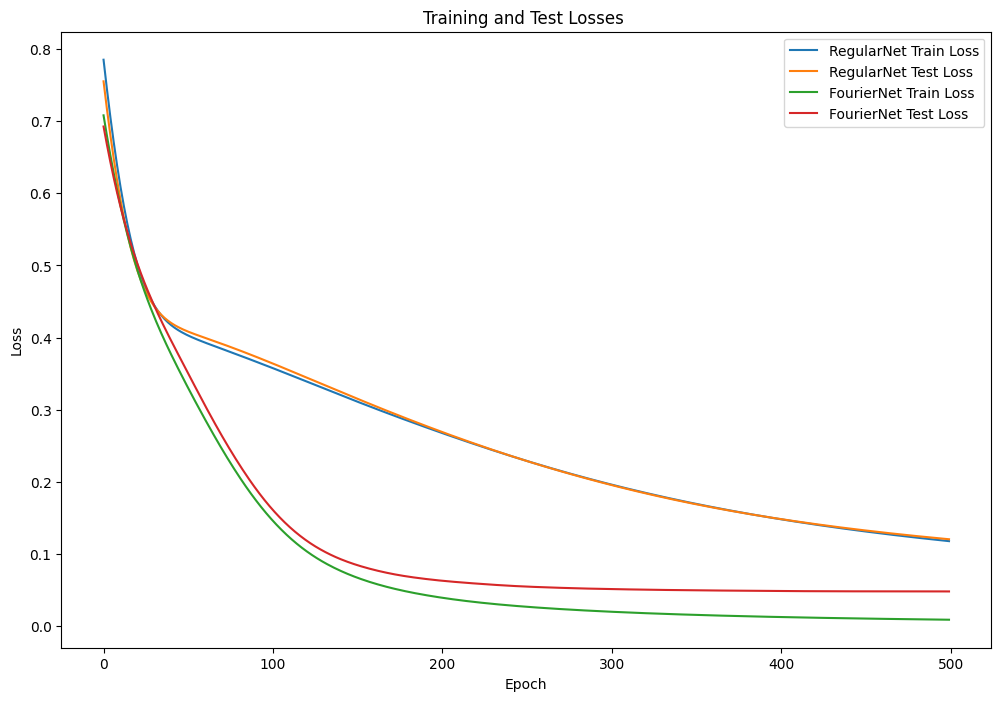

In [36]:
plt.figure(figsize=(12, 8))

plt.plot(train_loss_regular, label='RegularNet Train Loss')
plt.plot(test_loss_regular, label='RegularNet Test Loss')

plt.plot(train_loss_fourier, label='FourierNet Train Loss')
plt.plot(test_loss_fourier, label='FourierNet Test Loss')

plt.title('Training and Test Losses ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Zadanie 3
Napisz i wytrenuj model którego zadaniem bedzie zapamiętanie zdjęcia. Jako loss używaj funkcji loss z pierwszego zadania.
Zdjęciem które bedzie należy zapamietać jest org_smaller.jpg

Dla modelu bez FF proponuje następującą strukture:

1.
    * Conv2d( 3, 256, kernel_size=1, padding=0)
    * ReLU()
    * BatchNorm2d(256)
2.
    * Conv2d(256, 256, kernel_size=1, padding=0)
    * ReLU()
    * BatchNorm2d(256)
3.
    * Conv2d(256, 256, kernel_size=1, padding=0)
    * ReLU()
    * BatchNorm2d(256)
4. Conv2d(256, 3, kernel_size=1, padding=0)
5. Sigmoid()

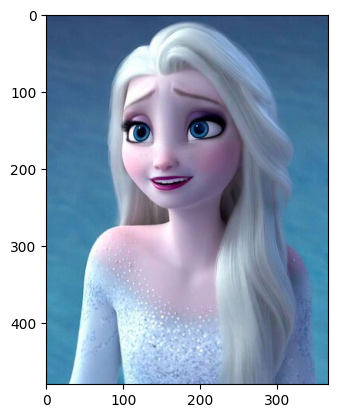

target:  torch.Size([1, 3, 480, 366])


In [37]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(path):
    image = Image.open(path)
    transform = transforms.PILToTensor()
    return transform(image) / 255

elza = load_image('elza/org_smaller.jpg') 
plt.imshow(elza.permute(1, 2, 0).numpy())
plt.show()

target = elza.unsqueeze(0).to(device) 

print("target: ", target.shape)

coordsw = np.linspace(0, 1, target.shape[2], endpoint=False)
coordsh = np.linspace(0, 1, target.shape[3], endpoint=False)
xy_grid = np.stack(np.meshgrid(coordsh, coordsw), -1)
xy_grid = torch.tensor(xy_grid).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(device)

Epoch 0, loss = 0.062


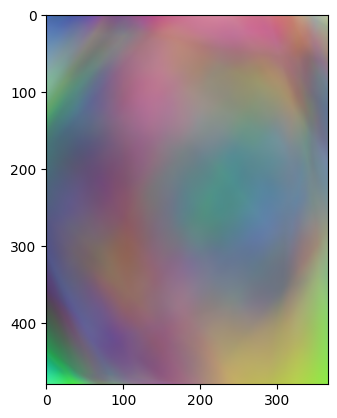

Epoch 100, loss = 0.018


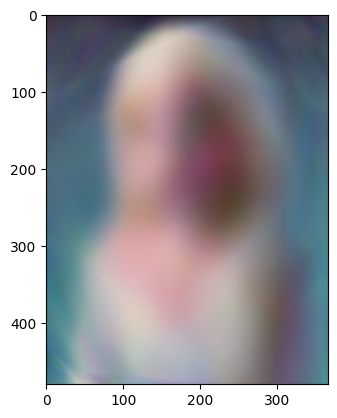

Epoch 200, loss = 0.012


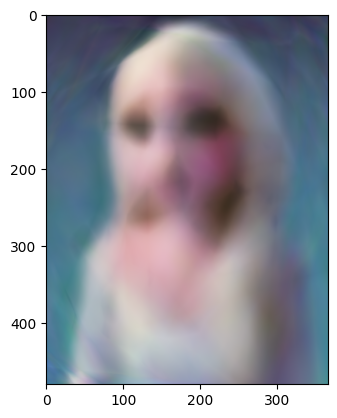

Epoch 300, loss = 0.008


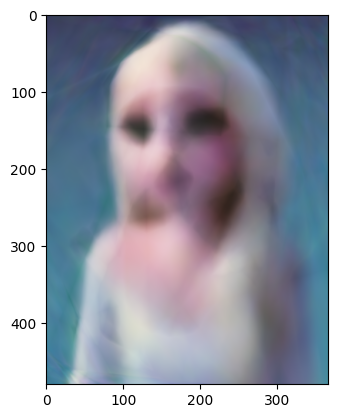

Epoch 400, loss = 0.005


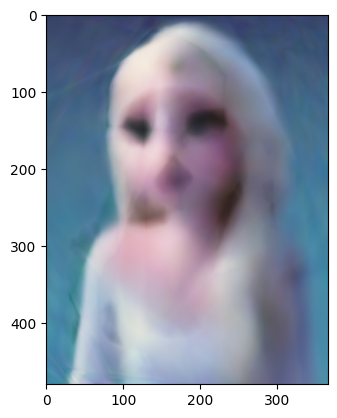

In [38]:
import torch.nn as nn

class ImageRemember(nn.Module):
    def __init__(self):
        super(ImageRemember, self).__init__()
         # początek kodu niewidocznego dla studentów
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 256, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256))

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256))

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 3, kernel_size=1, padding=0),
            nn.Sigmoid())
         # koniec kodu niewidocznego dla studentów

    def forward(self, x):
         # początek kodu niewidocznego dla studentów
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
          # koniec kodu niewidocznego dla studentów
        
        return x

imageModel = ImageRemember().to(device)

optimizer = torch.optim.Adam(list(imageModel.parameters()), lr=1e-4)

for epoch in range(401):
     # początek kodu niewidocznego dla studentów
    optimizer.zero_grad()

    generated = imageModel(xy_grid)

    loss = image_loss(generated, target)

    loss.backward()
    optimizer.step()
    # koniec kodu niewidocznego dla studentów

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(generated[0].permute(1, 2, 0).detach().cpu().numpy())
      plt.show()

## Zadanie 4
Napisz klasę / funkcje która będzie robić FourierFeature dla wejścia z poprzedniego zadania.
Funkcja ta powinna przyjmować parametry:

scale - przemnaża macierz B
width - szerokosc macierzy B
height - wyskosc macierzy B


In [1]:
import numpy as np
import torch

def gaussian_fourier_feature_transform(x, num_input_channels, mapping_size=256, scale=10):
     # początek kodu niewidocznego dla studentów
    B = torch.randn((num_input_channels, mapping_size)) * scale
    batches, channels, width, height = x.shape
    
    x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)
    x = x @ B.to(x.device)

    x = x.view(batches, width, height, mapping_size)
    x = x.permute(0, 3, 1, 2)

    x = 2 * np.pi * x
      # koniec kodu niewidocznego dla studentów
    return torch.cat([torch.sin(x), torch.cos(x)], dim=1)

In [2]:
x = torch.tensor([[[[1., 2.], [3., 4.]]]])
num_input_channels = 1
mapping_size = 2
scale = 1

torch.manual_seed(0)
transformed = gaussian_fourier_feature_transform(x, num_input_channels, mapping_size, scale)

expected = torch.tensor(
    [[[[-0.2547,  0.4927],
       [-0.6981,  0.8575]],
      [[-0.9630,  0.5191],
       [ 0.6832, -0.8873]],
      [[-0.9670,  0.8702],
       [-0.7160,  0.5145]],
      [[-0.2695, -0.8547],
       [ 0.7302,  0.4612]]]])

print("Output:\n", transformed)
print(torch.allclose(transformed, expected, atol=1e-4))


Output:
 tensor([[[[-0.2547,  0.4927],
          [-0.6981,  0.8575]],

         [[-0.9630,  0.5191],
          [ 0.6832, -0.8873]],

         [[-0.9670,  0.8702],
          [-0.7160,  0.5145]],

         [[-0.2695, -0.8547],
          [ 0.7302,  0.4612]]]])
True


## Zadanie 5
Napisz i wytrenuj model który bedzie miał podobną strukture jak ten z zadania 3, z tą różnicą że wejścia zostaną przetworzone używając Fourier Feature. Jako loss używaj funkcji loss z pierwszego zadania.


Model o nastepującej strukturze będzie w zupełności wystarczający: 

1. 
    * Conv2d( 256,256,kernel_size=1,padding=0)
    * ReLU()
    * BatchNorm2d(256)
2.
    * Conv2d(256,256,kernel_size=1,padding=0)
    * ReLU()
    * BatchNorm2d(256)
3.
    * Conv2d(256,256,kernel_size=1,padding=0)
    * ReLU()
    * BatchNorm2d(256)

4. Conv2d(256,3,kernel_size=1,padding=0)
5. Sigmoid()

Spróbuj znaleźć najlepsze parametry dla których sieć najlepiej zapamiętuje zdjęcie.
Opisz co sie dzieje jeżeli L będzie za małe lub leżeli L będzie za duże.
Jak jego wartość wpływa na uczenie sieci

Epoch 0, loss = 0.069


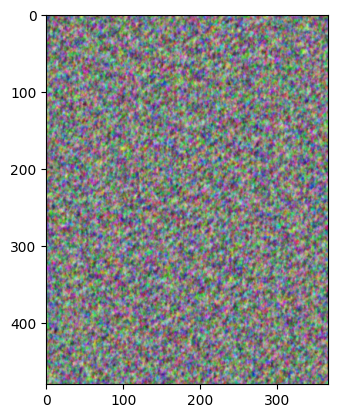

Epoch 100, loss = 0.028


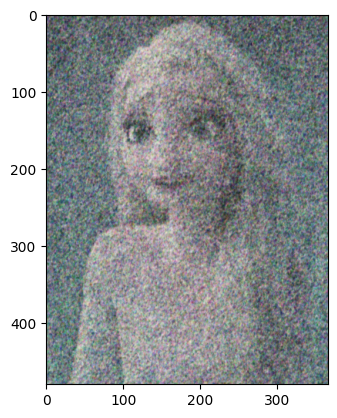

Epoch 200, loss = 0.012


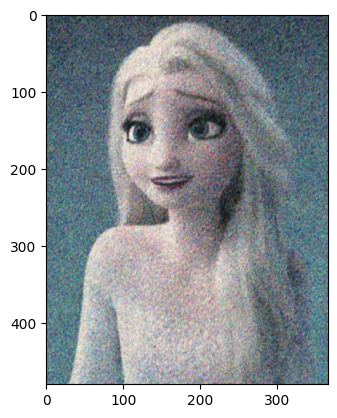

Epoch 300, loss = 0.007


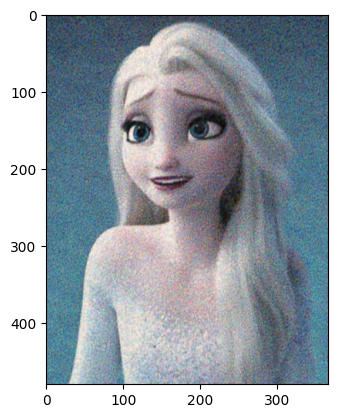

Epoch 400, loss = 0.004


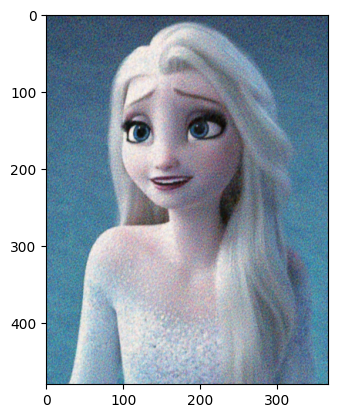

In [41]:
K_SIZE = 256

class FurierImageRemember(nn.Module):
    def __init__(self):
        super(FurierImageRemember, self).__init__()
         # początek kodu niewidocznego dla studentów
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(K_SIZE, K_SIZE, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(K_SIZE))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(K_SIZE, K_SIZE, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(K_SIZE))

        self.layer3 = nn.Sequential(
            nn.Conv2d(K_SIZE, K_SIZE, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(K_SIZE))

        self.layer4 = nn.Sequential(
            nn.Conv2d(K_SIZE, 3, kernel_size=1, padding=0),
            nn.Sigmoid())
         # koniec kodu niewidocznego dla studentów

    def forward(self, x):
         # początek kodu niewidocznego dla studentów
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
         # koniec kodu niewidocznego dla studentów
        return x

fourier = FurierImageRemember().to(device)

x = gaussian_fourier_feature_transform(xy_grid,2, K_SIZE//2, 30)

optimizer = torch.optim.Adam(list(fourier.parameters()), lr=1e-4)

for epoch in range(401):
     # początek kodu niewidocznego dla studentów
    optimizer.zero_grad()

    generated = fourier(x)

    loss = image_loss(target, generated)

    loss.backward()
    optimizer.step()
      # koniec kodu niewidocznego dla studentów

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(generated[0].permute(1, 2, 0).detach().cpu().numpy())
      plt.show()
